In [93]:
import pandas as pd
import gzip
import json
from bs4 import BeautifulSoup
import unidecode
import re
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline

In [94]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')


In [95]:
headphones_df = pd.read_csv("Speaker_final.csv")

In [96]:
headphones_df

,Unnamed: 0,overall,reviewTime,reviewerID,asin,reviewText,title,brand
0,0,4.0,"12 3, 2006",A2HC6DS4I7S0ES,9864216155,"I got these speakers as a gift, then found the...",digilife fold-up compact speakers for apple ip...,DekCell
1,1,5.0,"05 27, 2009",A2SVY0DOZXES6I,9864216155,I purchased I used a little and worked good no...,digilife fold-up compact speakers for apple ip...,DekCell
2,2,3.0,"09 16, 2007",A29CJQQHNW7WH7,9864216155,See title........1st unit's battery compartmen...,digilife fold-up compact speakers for apple ip...,DekCell
3,3,3.0,"04 12, 2011",A6QM463S99US1,9864216155,"The design is truly small, good for travels. T...",digilife fold-up compact speakers for apple ip...,DekCell
4,4,5.0,"05 23, 2010",AK5YXIUQV9DZ3,9864216155,These are a great value. The sound is great. ...,digilife fold-up compact speakers for apple ip...,DekCell
...,...,...,...,...,...,...,...,...
43346,46317,4.0,"07 29, 2016",A7P70JZBBATVM,B01H88JV6A,"This is a convenient package, which plays musi...",tecbox wireless 3.0 bluetooth speakers led pan...,TECBOX
43347,46318,5.0,"07 29, 2016",A3P8Z4OR28VZFS,B01H88JV6A,"For the past month or so, I have been looking ...",tecbox wireless 3.0 bluetooth speakers led pan...,TECBOX
43348,46319,5.0,"07 27, 2016",A2JHEJA03Q94NB,B01H88JV6A,The box it came in said mini HiFi .Well there ...,tecbox wireless 3.0 bluetooth speakers led pan...,TECBOX
43349,46320,5.0,"07 10, 2016",A2ON4RYI9Z4SQ,B01H88JV6A,Review of TECBOX Ultra Portable Bluetooth 3.0 ...,tecbox wireless 3.0 bluetooth speakers led pan...,TECBOX


In [97]:
print(headphones_df.iloc[1])

Unnamed: 0                                                    1
overall                                                     5.0
reviewTime                                          05 27, 2009
reviewerID                                       A2SVY0DOZXES6I
asin                                                 9864216155
reviewText    I purchased I used a little and worked good no...
title         digilife fold-up compact speakers for apple ip...
brand                                                   DekCell
Name: 1, dtype: object


In [98]:
headphones_df.drop_duplicates(inplace=True)
headphones_df['reviewText'] = headphones_df['reviewText'].fillna("")
headphones_df.dropna(inplace=True)

In [99]:
total_rows = len(headphones_df)
print("Total number of rows after pre-processing:", total_rows)

Total number of rows after pre-processing: 43338


In [100]:
number_of_reviews = headphones_df.shape[0]

average_rating_score = headphones_df['overall'].mean()

number_of_unique_products = headphones_df['asin'].nunique()

number_of_good_ratings = headphones_df[headphones_df['overall'] >= 3].shape[0]

number_of_bad_ratings = headphones_df[headphones_df['overall'] < 3].shape[0]

reviews_per_rating = headphones_df['overall'].value_counts().sort_index()

print("a. Number of Reviews:", number_of_reviews)
print("b. Average Rating Score:", average_rating_score)
print("c. Number of Unique Products:", number_of_unique_products)
print("d. Number of Good Ratings:", number_of_good_ratings)
print("e. Number of Bad Ratings:", number_of_bad_ratings)
print("f. Number of Reviews corresponding to each Rating:")
print(reviews_per_rating)


a. Number of Reviews: 43338
b. Average Rating Score: 4.27380128293876
c. Number of Unique Products: 1194
d. Number of Good Ratings: 38871
e. Number of Bad Ratings: 4467
f. Number of Reviews corresponding to each Rating:
overall
1.0     2367
2.0     2100
3.0     3655
4.0     8394
5.0    26822
Name: count, dtype: int64


In [101]:
text_column = 'reviewText'

headphones_df[text_column] = headphones_df[text_column].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

headphones_df[text_column] = headphones_df[text_column].apply(lambda x: unidecode.unidecode(x))

acronyms = {'lol': 'laugh out loud', 'brb': 'be right back'}
headphones_df[text_column] = headphones_df[text_column].apply(lambda x: ' '.join([acronyms.get(word.lower(), word) for word in x.split()]))

headphones_df[text_column] = headphones_df[text_column].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

lemmatizer = WordNetLemmatizer()
headphones_df[text_column] = headphones_df[text_column].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, wordnet.VERB) for word in word_tokenize(x)]))

stop_words = set(stopwords.words('english'))
headphones_df[text_column] = headphones_df[text_column].apply(lambda x: ' '.join([word.lower() for word in word_tokenize(x) if word.lower() not in stop_words]))


C:\Users\DEVANSH\AppData\Local\Temp\ipykernel_38024\231960610.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  headphones_df[text_column] = headphones_df[text_column].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())


In [102]:
headphones_df

,Unnamed: 0,overall,reviewTime,reviewerID,asin,reviewText,title,brand
0,0,4.0,"12 3, 2006",A2HC6DS4I7S0ES,9864216155,get speakers gift find amazon amazingly good p...,digilife fold-up compact speakers for apple ip...,DekCell
1,1,5.0,"05 27, 2009",A2SVY0DOZXES6I,9864216155,purchase use little work good complaint especi...,digilife fold-up compact speakers for apple ip...,DekCell
2,2,3.0,"09 16, 2007",A29CJQQHNW7WH7,9864216155,see titlest units battery compartment smoke me...,digilife fold-up compact speakers for apple ip...,DekCell
3,3,3.0,"04 12, 2011",A6QM463S99US1,9864216155,design truly small good travel sound quality g...,digilife fold-up compact speakers for apple ip...,DekCell
4,4,5.0,"05 23, 2010",AK5YXIUQV9DZ3,9864216155,great value sound great buy two one sister one...,digilife fold-up compact speakers for apple ip...,DekCell
...,...,...,...,...,...,...,...,...
43346,46317,4.0,"07 29, 2016",A7P70JZBBATVM,B01H88JV6A,convenient package play music several source b...,tecbox wireless 3.0 bluetooth speakers led pan...,TECBOX
43347,46318,5.0,"07 29, 2016",A3P8Z4OR28VZFS,B01H88JV6A,past month look little bluetooth speaker could...,tecbox wireless 3.0 bluetooth speakers led pan...,TECBOX
43348,46319,5.0,"07 27, 2016",A2JHEJA03Q94NB,B01H88JV6A,box come say mini hifi well nothing mini excep...,tecbox wireless 3.0 bluetooth speakers led pan...,TECBOX
43349,46320,5.0,"07 10, 2016",A2ON4RYI9Z4SQ,B01H88JV6A,review tecbox ultra portable bluetooth wireles...,tecbox wireless 3.0 bluetooth speakers led pan...,TECBOX


Top 20 most reviewed brands:
brand
Logitech              4540
Pyle                  2582
Polk Audio            2183
BOSS Audio Systems    1660
Yamaha Audio          1524
Bose                  1259
Sony                  1102
Dual Electronics      1048
GOgroove              1038
Pioneer                849
Edifier                762
Featured Brands 4      729
Kenwood                655
Kicker                 618
August                 572
Yamaha                 540
Satechi                443
JBL                    417
GearIT                 404
Earise                 394
Name: count, dtype: int64
Top 20 least reviewed brands:
brand
Veboost            5
FULLLIGHT TECH     5
Cineyo             5
Hype               5
Legrand-On-Q       5
Best Kits          5
Mediabridge        5
Pagreberya         5
ETONG              5
Zonkyo             5
Millennia          5
BAVISION           5
T POWER            5
Enrock             5
Xinglan            5
Ipevo              5
Importer520        5
TIC CO

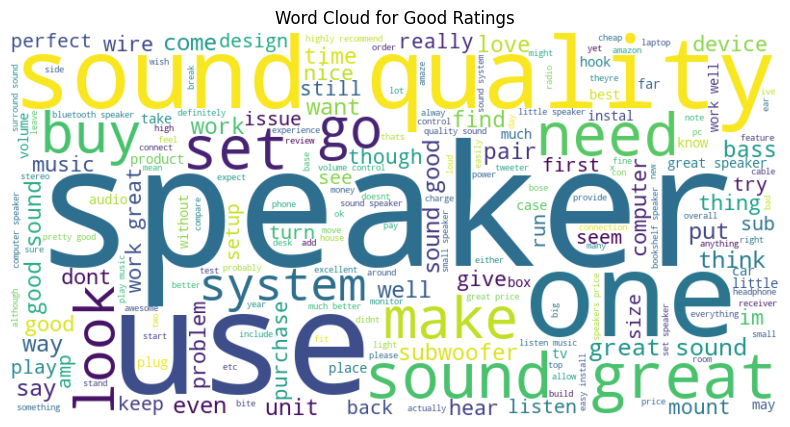

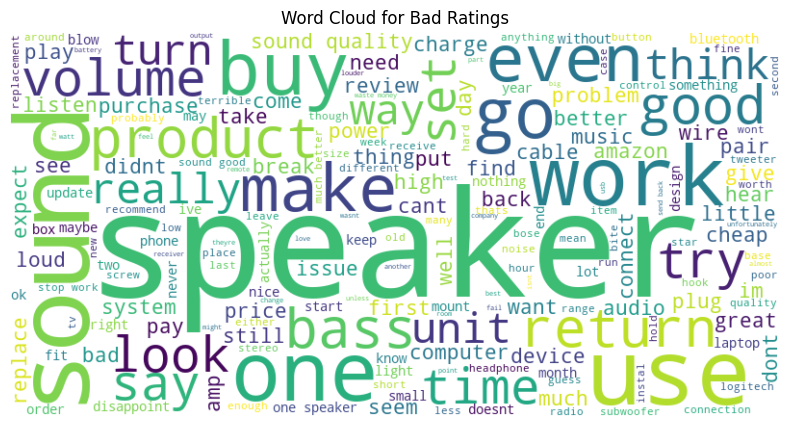

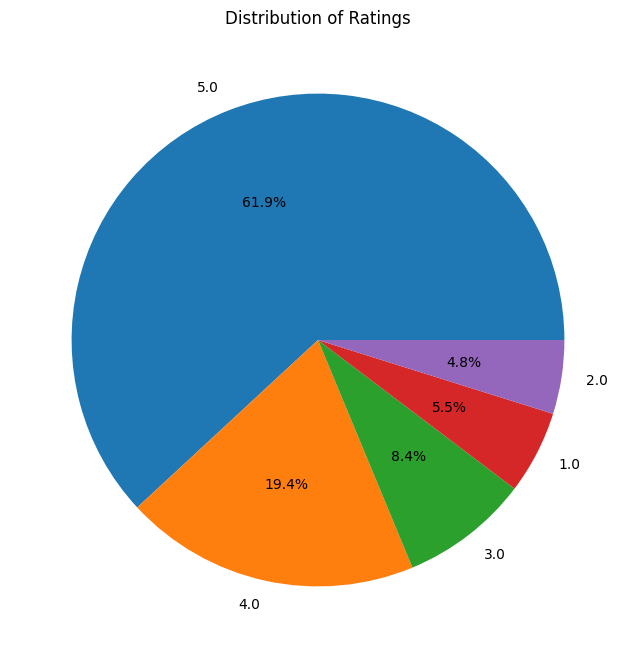

Year with maximum reviews: 2016
Year with the highest number of customers: 2016


In [103]:
top_20_most_reviewed_brands = headphones_df['brand'].value_counts().head(20)
print("Top 20 most reviewed brands:")
print(top_20_most_reviewed_brands)
top_20_least_reviewed_brands = headphones_df['brand'].value_counts().tail(20)
print("Top 20 least reviewed brands:")
print(top_20_least_reviewed_brands)
most_positively_reviewed = headphones_df[headphones_df['overall'] == 5.0]['brand'].value_counts().idxmax()
print("Most positively reviewed brand:", most_positively_reviewed)
headphones_df['date'] = pd.to_datetime(headphones_df['reviewTime'], errors='coerce')

headphones_df = headphones_df.dropna(subset=['reviewTime'])

most_used=headphones_df.groupby(headphones_df['asin']).size().idxmax()
print("Most bought product: ",most_used)

ratings_over_years = headphones_df.groupby(headphones_df['date'].dt.year)['overall'].value_counts().unstack().fillna(0)
ratings_over_years = ratings_over_years.loc[:, 1:]  # Exclude ratings with value 0
print("Count of ratings for the product over 5 consecutive years:")
print(ratings_over_years)
from wordcloud import WordCloud
import matplotlib.pyplot as plt

good_reviews = headphones_df[headphones_df['overall'] >= 3.0]['reviewText'].str.cat(sep=' ')
wordcloud_good = WordCloud(width=800, height=400, background_color='white').generate(good_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_good, interpolation='bilinear')
plt.title('Word Cloud for Good Ratings')
plt.axis('off')
plt.show()


bad_reviews = headphones_df[headphones_df['overall'] < 3.0]['reviewText'].str.cat(sep=' ')
wordcloud_bad = WordCloud(width=800, height=400, background_color='white').generate(bad_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_bad, interpolation='bilinear')
plt.title('Word Cloud for Bad Ratings')
plt.axis('off')
plt.show()

ratings_distribution = headphones_df['overall'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(ratings_distribution, labels=ratings_distribution.index, autopct='%1.1f%%')
plt.title('Distribution of Ratings')
plt.show()
year_with_max_reviews = headphones_df.groupby(pd.to_datetime(headphones_df['reviewTime']).dt.year).size().idxmax()
print("Year with maximum reviews:", year_with_max_reviews)
year_with_highest_customers = headphones_df.groupby(pd.to_datetime(headphones_df['reviewTime']).dt.year)['reviewerID'].nunique().idxmax()
print("Year with the highest number of customers:", year_with_highest_customers)


In [104]:
columns_to_include = [col for col in headphones_df.columns if col != 'rating_class']

def encode_rating_class(rating):
    if rating > 3:
        return 'Good'
    elif rating == 3:
        return 'Average'
    else:
        return 'Bad'

headphones_df['rating_class'] = headphones_df['overall'].apply(encode_rating_class)

X_train, X_test, y_train, y_test = train_test_split(headphones_df[columns_to_include], headphones_df['rating_class'], test_size=0.25, random_state=42)

tfidf_vectorizer = TfidfVectorizer(stop_words='english')

In [105]:
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=2500),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Linear Support Vector Machine": LinearSVC(max_iter=2500)
}

for name, model in models.items():
    pipeline = Pipeline([
        ('tfidf', tfidf_vectorizer),
        ('model', model)
    ])
    pipeline.fit(X_train['reviewText'], y_train)
    y_pred = pipeline.predict(X_test['reviewText'])
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))

Model: Decision Tree
              precision    recall  f1-score   support

     Average       0.23      0.18      0.20       935
         Bad       0.44      0.43      0.43      1073
        Good       0.88      0.91      0.89      8827

    accuracy                           0.80     10835
   macro avg       0.52      0.50      0.51     10835
weighted avg       0.78      0.80      0.79     10835

Model: Logistic Regression
              precision    recall  f1-score   support

     Average       0.46      0.11      0.17       935
         Bad       0.71      0.52      0.60      1073
        Good       0.88      0.98      0.93      8827

    accuracy                           0.86     10835
   macro avg       0.69      0.54      0.57     10835
weighted avg       0.83      0.86      0.83     10835



In [ ]:
headphones_df=pd.read_csv("floppy_final.csv")

In [ ]:
user_item_matrix = headphones_df.pivot_table(values='overall', index='reviewerID', columns='asin',fill_value=0)

user_item_matrix_normalized = (user_item_matrix - user_item_matrix.min()) / (user_item_matrix.max() - user_item_matrix.min())

def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

def cosine_similarity_matrix(matrix):
    similarity_matrix = np.zeros((matrix.shape[0], matrix.shape[0]))
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[0]):
            similarity_matrix[i, j] = cosine_similarity(matrix[i], matrix[j])
    return similarity_matrix

def predict_ratings_user_user(similarity_matrix, train_set, val_set, k_neighbors):
    predicted_ratings = np.zeros_like(val_set.values)
    for i, user in enumerate(val_set.index):
        if user in train_set.index:
            top_k_similar_users = similarity_matrix[train_set.index.get_loc(user)].argsort()[::-1][1:k_neighbors+1]
            for j, item in enumerate(val_set.columns):
                if item in train_set.columns and val_set.loc[user, item] == 0:
                    # Predict rating for missing value
                    numerator = np.sum(similarity_matrix[train_set.index.get_loc(user), top_k_similar_users] * train_set.loc[train_set.index[top_k_similar_users], item])
                    denominator = np.sum(np.abs(similarity_matrix[train_set.index.get_loc(user), top_k_similar_users]))
                    if denominator != 0:
                        predicted_ratings[i, j] = numerator / denominator
    return predicted_ratings

def calculate_mae(predicted_ratings, actual_ratings):
    mask = actual_ratings != 0
    predicted_ratings_masked = predicted_ratings[mask]
    actual_ratings_masked = actual_ratings[mask]
    return np.mean(np.abs(predicted_ratings_masked - actual_ratings_masked))


kf = KFold(n_splits=5, shuffle=True)

mae_results_user_user = {}
for k_neighbors in [10, 20, 30, 40, 50]:
    fold_mae = []
    for train_index, val_index in kf.split(user_item_matrix_normalized):
        train_set = user_item_matrix_normalized.iloc[train_index]
        val_set = user_item_matrix_normalized.iloc[val_index]
        
        similarity_matrix = cosine_similarity_matrix(train_set.values)
        predicted_ratings = predict_ratings_user_user(similarity_matrix, train_set, val_set, k_neighbors)
        fold_mae.append(calculate_mae(predicted_ratings, val_set.values))
    mae_results_user_user[k_neighbors] = np.mean(fold_mae)

def predict_ratings_item_item(similarity_matrix, train_set, val_set, k_neighbors):
    predicted_ratings = np.zeros_like(val_set.values)
    for i, user in enumerate(val_set.index):
        if user in train_set.index:
            for j, item in enumerate(val_set.columns):
                if item in train_set.columns and val_set.loc[user, item] == 0:
                    # Predict rating for missing value
                    top_k_similar_items = similarity_matrix[train_set.columns.get_loc(item)].argsort()[::-1][1:k_neighbors+1]
                    numerator = np.sum(similarity_matrix[train_set.columns.get_loc(item), top_k_similar_items] * train_set.loc[user, train_set.columns[top_k_similar_items]])
                    denominator = np.sum(np.abs(similarity_matrix[train_set.columns.get_loc(item), top_k_similar_items]))
                    if denominator != 0:
                        predicted_ratings[i, j] = numerator / denominator
    return predicted_ratings
mae_results_item_item = {}
for k_neighbors in [10, 20, 30, 40, 50]:
    fold_mae = []
    for train_index, val_index in kf.split(user_item_matrix_normalized):
        train_set = user_item_matrix_normalized.iloc[train_index]
        val_set = user_item_matrix_normalized.iloc[val_index]
        
        similarity_matrix = cosine_similarity_matrix(train_set.transpose().values)
        predicted_ratings = predict_ratings_item_item(similarity_matrix, train_set, val_set, k_neighbors)
        fold_mae.append(calculate_mae(predicted_ratings, val_set.values))
    mae_results_item_item[k_neighbors] = np.mean(fold_mae)

plt.figure(figsize=(10, 5))
plt.plot(list(mae_results_user_user.keys()), list(mae_results_user_user.values()), label='User-User Recommender')
plt.title('Mean Absolute Error (MAE) vs. Number of Neighbors (K)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()

print("Top 10 Products by User Sum Ratings:")
top_products = user_item_matrix.sum(axis=0).sort_values(ascending=False).head(10)
print(top_products)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(list(mae_results_item_item.keys()), list(mae_results_item_item.values()), label='Item-Item Recommender')
plt.title('Mean Absolute Error (MAE) vs. Number of Neighbors (K)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()